In [1]:
import os
import argparse
import random
import time
from typing import Optional

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Define Class
from torch import Tensor
from torch.nn.modules import Module
from torch.nn.modules.loss import _Loss
from torch.optim.optimizer import Optimizer
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import random_split, Dataset

from torchvision import transforms

import model
''' Micro-Batch Streaming '''
from mbs import MicroBatchStreaming
from conf import settings

## Setup

In [2]:
## Random Seed
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(random_seed)

## Setup train epochs
epochs = 3

## Setup Optimizer
lr = 1e-4

## Setup Dataloader
carvana_mean = [0.0, 0.0, 0.0]
carvana_std = [1.0, 1.0, 1.0]
batch_size = 4
shuffle = True
num_workers = 6
image_scale = 1/4
train_val_split = 0.1

## Setup  GPU
gpu_index = 0
gpu = torch.device(f"cuda:{gpu_index}")

## Train function

In [3]:
def train(
    epoch: int, total_epoch: int,
    device: torch.device,
    model: Module, 
    criterion: _Loss, 
    optimizer: Optimizer, 
    dataloader: DataLoader
):
    loss: Tensor
    dice: Tensor
    losses = []
    dataloader_len = len(dataloader)
    model.train()
    for idx, (inputs, masks) in enumerate(dataloader):
        inputs: Tensor = inputs.to(device)
        masks: Tensor = masks.to(device)

        optimizer.zero_grad()
        preds: Tensor = model( inputs )
        loss, dice = criterion( preds, masks )
        loss.backward()
        optimizer.step()

        losses.append( loss.item() )
    print(
        f"Epoch [{epoch+1}/{total_epoch}][{idx+1}/{dataloader_len}]\t",
        f"train loss : {sum(losses)/len(losses):.4f}\t",
        f"input image size: {inputs.size()}",
    )

## Validation function

In [4]:
def validation(
    device: torch.device,
    model: Module, 
    criterion: _Loss,
    dataloader: DataLoader
):
    correct = 0.0
    test_num = 0.0
    test_losses = []
    model.eval()
    for idx, (inputs, masks) in enumerate(dataloader):
        inputs: Tensor = inputs.to(device)
        masks: Tensor = masks.to(device)

        preds: Tensor = model( inputs )
        loss: Tensor = criterion(preds, masks)

        test_losses.append( loss.item() )
        _, pred = preds.max(1)

        equal_factor = pred.eq(masks).sum()
        test_num += masks.nelement()
        correct += equal_factor
        corrects = 100 * ( correct * test_num )

    print(
        f"\nval loss: {sum(test_losses)/len(test_losses):.4f}\t",
        f"Accuracy: {corrects}%"
    )

## Carvana Dataset

In [5]:
class  CarvanaDataset(Dataset):
    def __init__(
        self,
        root: str = "data",
        image_transform: transforms = None,
        mask_transform: transforms = None
    ) -> None:
        super().__init__()
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_path = os.path.join( root, "train" )
        self.mask_path = os.path.join( root, "train_masks" )

        self.images = os.listdir( self.image_path )
        self.masks = os.listdir( self.mask_path )
        assert len(self.images) == len(self.masks), "The length does not equal!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_path, self.images[index])
        mask_path = os.path.join(self.mask_path, self.images[index])
        mask_path = mask_path.split(".")[0] + '_mask.gif'

        image = np.array( Image.open( image_path ).convert("RGB") )
        mask = np.array( Image.open( mask_path ).convert("L"), dtype=np.float32 )
        mask[mask == 255.0] = 1.0

        if self.image_transform is not None:
            image = self.image_transform( image )
        if self.mask_transform is not None:
            mask = self.mask_transform( mask )

        return image, mask

## Define Dataloader

In [6]:
# Setup transforms for inputs and masks
image_compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(carvana_mean, carvana_std),
        transforms.Resize( ( int(1280 * image_scale), int(1918 * image_scale) ) )
    ])
masks_compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize( ( int(1280 * image_scale), int(1918 * image_scale) ) )
    ])

# Define dataset
carvana_dataset = CarvanaDataset(
    root='data',
    image_transform=image_compose,
    mask_transform=masks_compose 
)

# Split dataset
num_val     = int( len(carvana_dataset) * train_val_split )
num_train   = len(carvana_dataset) - num_val
train_dataset, val_dataset =  random_split(
    carvana_dataset,
    [num_train, num_val],
    generator=torch.Generator().manual_seed(random_seed)
)

# Define dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

## Ploting Images

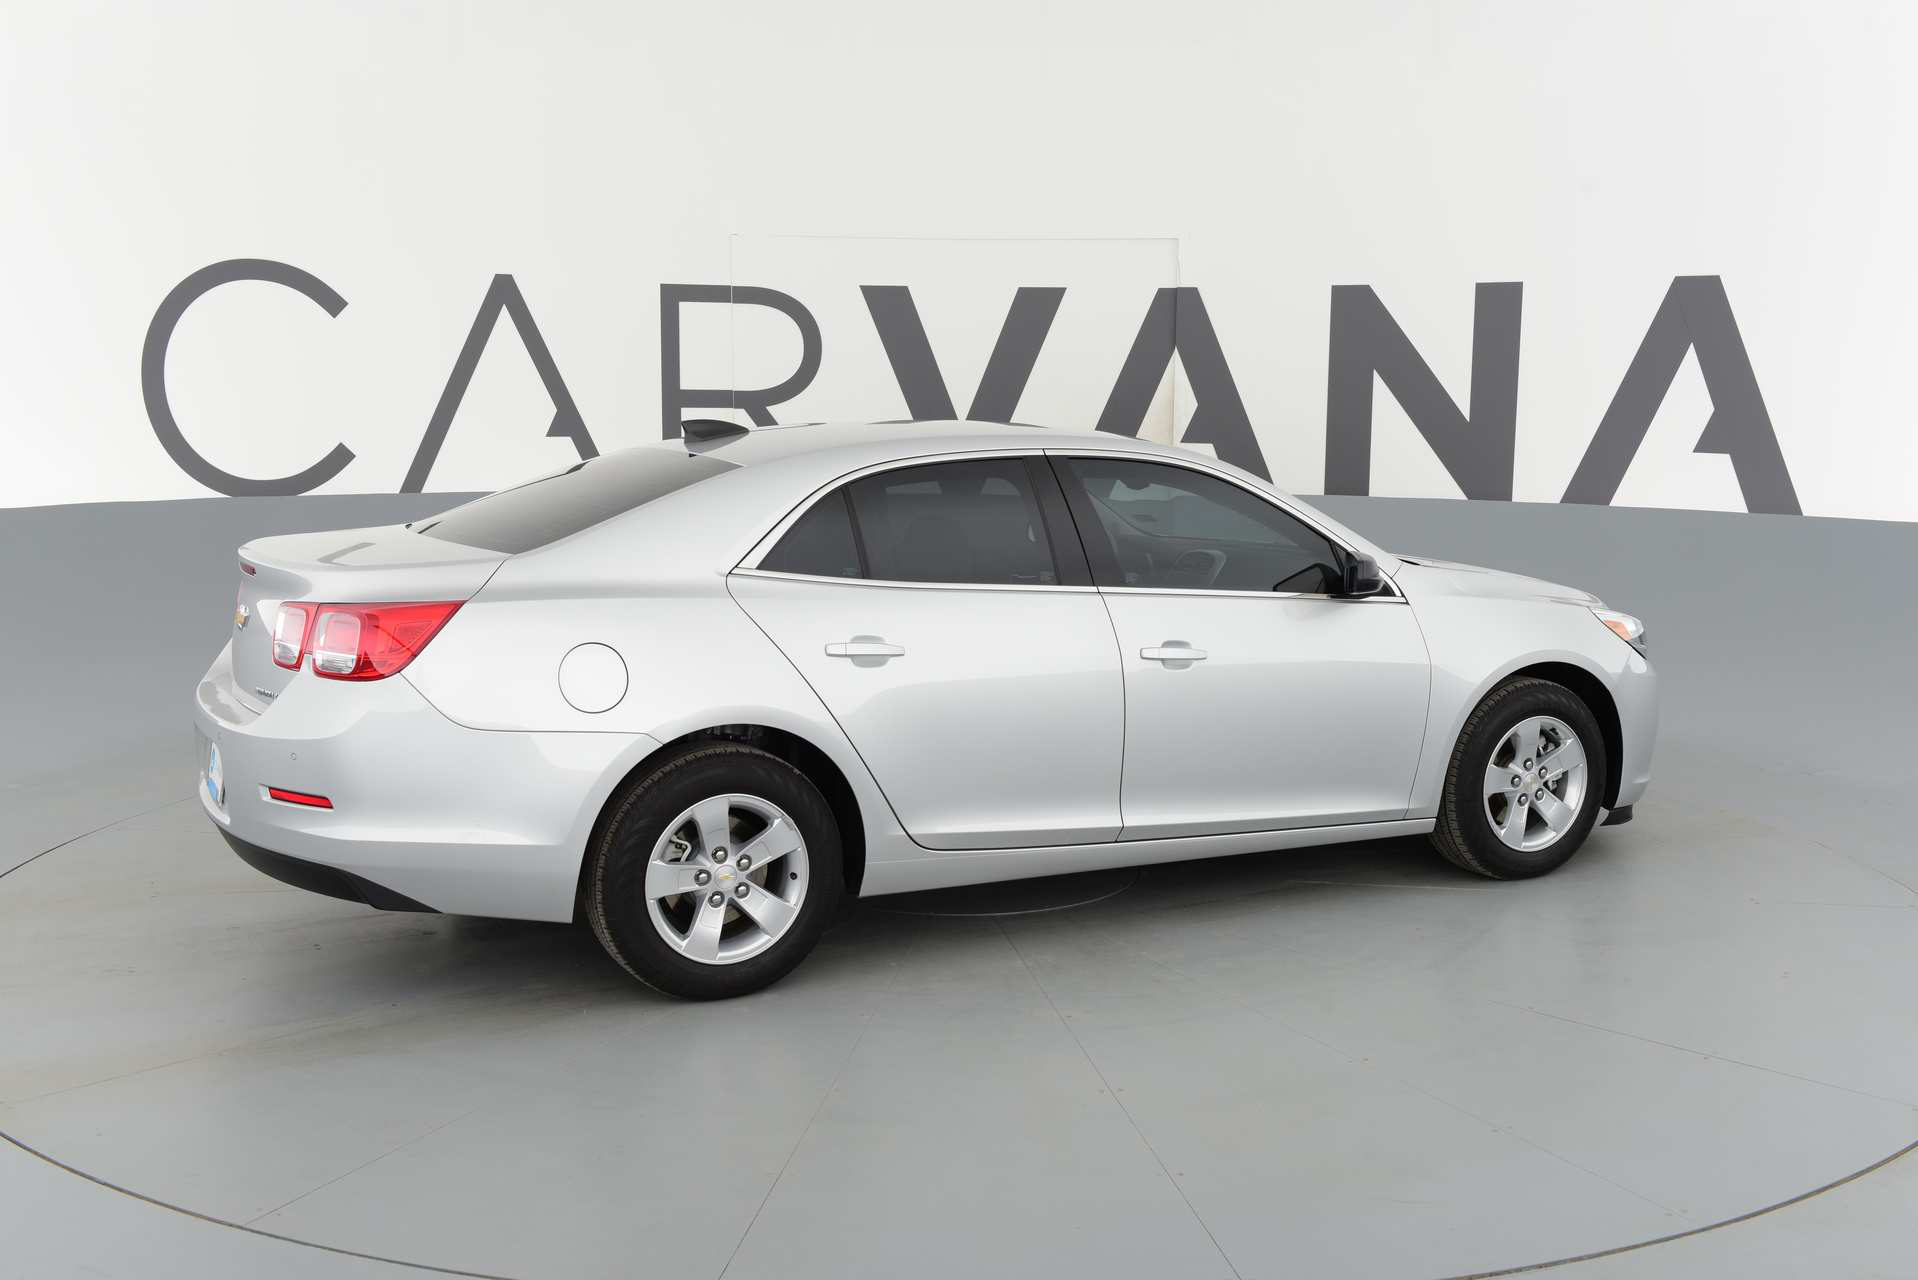

In [12]:
import matplotlib.pyplot as plt

DATA_PATH = 'data'
image_path = os.path.join( DATA_PATH, "train" )
mask_path = os.path.join( DATA_PATH, "train_masks" )

images = os.listdir( image_path )
masks = os.listdir( mask_path )

i = 30

image_ = Image.open( os.path.join( image_path, images[i] ) ).convert("RGB")
mask_ = Image.open( os.path.join( mask_path, masks[i] ) ).convert("L")
mask_use_image_index = Image.open( 
        os.path.join( mask_path, images[i].replace(".jpg", "_mask.gif") )
    ).convert("L")

# plt.figure(figsize=(20, 20))

# plt.subplot(131)
# plt.imshow(image_)
# plt.subplot(132)
# plt.imshow(mask_)
# plt.subplot(133)
# plt.imshow(mask_use_image_index)
image_.show()
mask_.show()
mask_use_image_index.show()


## Define Specific Loss (Criterion)

In [7]:
def dice_loss(pred: Tensor, mask: Tensor, smooth: int = 1e-5):
    bce_output = F.binary_cross_entropy_with_logits(
        pred, mask, reduction="sum"
    )
    pred = torch.sigmoid(pred)
    intersection = (pred * mask).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + mask.sum(dim=(2,3))
    
    # dice coefficient
    dice = 2.0 * (intersection + smooth) / (union + smooth)
    
    # dice loss
    dice_loss = 1.0 - dice
    
    # total loss
    loss: Tensor = bce_output + dice_loss
    return loss.sum(), dice.sum()

## Define Model, Criterion, Optimizer

In [8]:
from utils import get_network_name

unet = get_network_name('unet3156').to(gpu)
# criterion = nn.BCEWithLogitsLoss().to(gpu)
criterion = dice_loss
optimizer = optim.Adam( unet.parameters(), lr=lr )

## Scheduler, WarmUP Define

In [9]:
pass

# Train

In [10]:
for epoch in range(epochs):
    train( epoch, epochs, gpu, unet, criterion, optimizer, train_dataloader )
    validation( gpu, unet, criterion, val_dataloader )

Epoch [1/3][1145/1145]	 train loss : 319884.7264	 input image size: torch.Size([4, 3, 320, 479])

val loss: 133810.2808	 Accuracy: 1.9082913530081444e+18%
